# notebook minist and different optimizers

the basis is kaiminig optimization and batchnorm

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import functools
from torch import torch
import torch.nn.functional as F

#let me be on my mac
def cuda(self, device=None, non_blocking=False) : return self
torch.Tensor.cuda = cuda

from lib.data.external import *
from lib.data.lists import *
from lib.learner.learner import *
from lib.learner.optimizers import *
from lib.image.image import *
from lib.model.model import*
from lib.model.modelmanager import*

from functools import *
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

## mnist data

In [ ]:

config   = MNIST_Configuration().initialize()
inputTfm = Transforms(Image2TensorImage(), NormalizeTransform(config.scale,config.mean,config.std))
ds       = config.dataset(input_transform = inputTfm, output_transform=Numpy2Tensor(dtype=int)  )
#files    = ImageList.from_files( untar_data(config.url) )
#ds       = ImageDataset(config, files, input_transform=inputTfm, output_transform=Numpy2Tensor(dtype=int)  )
ds_train, ds_test = ds.split2train_test()

dl_train, dl_test = ds_train.dataloader(128,True), ds_test.dataloader(512, False)
databunch = DataBunch(dl_train, dl_test, config.channels_in, config.channels_out)

len(ds), len(ds_train), len(ds_test),len(dl_train), len(dl_test), 

(70000, 60000, 10000, 469, 20)

In [ ]:
# average loss pr input sample at iteration 0
nb_classes = config.channels_out
initial_loss = -np.log( 1.0/nb_classes ) 
print(f"For equal distribution of cases pr class. nb_classes:{nb_classes}: \ninitial loss:    {initial_loss}\ninitial accuracy {1.0/nb_classes}")

For equal distribution of cases pr class. nb_classes:10: 
initial loss:    2.3025850929940455
initial accuracy 0.1


In [ ]:
layers_sizes = [8,16,32,32]
loss_func    = F.cross_entropy
sched        = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 

cbfs         = [TrainableModelCallback, TrainEvalCallback, OptimizerCallback, 
#                partial(CudaCallback, device= torch.device('cuda',0)),
#                partial(ParamScheduler, 'lr', sched),
                partial(BatchTransformXCallback, tfm = view_tfm(1,28,28)), 
#                partial(MixUp,α=0.4),
#                LR_Finder,
                
                Recorder, 
                partial(AvgStatsCallback,[accuracy]),
                ProgressCallback
               ]

## resnets + steppers=[sgd_step]

In [ ]:

opt = SGD(sched,max_lr=0.5)#0.5)
#loss_func=LabelSmoothingCrossEntropy()
mnist_view   = view_tfm(1,28,28)
loss_func=F.cross_entropy

layer = partial( conv_layer, stride=1, bn=False, zero_bn=False, act=GeneralRelu )
layer = partial( conv_layer, stride=1, bn=False, zero_bn=False, act=partial(torch.nn.ReLU,inplace=True) )
model = partial(xresnet18, c_in=databunch.c_in, c_out=databunch.c_out)()
#model = get_cnn_model(layers_sizes, databunch.c_in, databunch.c_out, layer=layer)
mm    = CnnModelManager( model )
mm.initialize(is_resnet=True)

xb,_ = mm.getFirstbatch( databunch, normalization = mnist_view)
print(f"input shape:{xb.shape}")
mm.summary(xb, print_mod=False)


input shape:torch.Size([128, 1, 28, 28])
<class 'torch.nn.modules.conv.Conv2d'> torch.Size([128, 16, 28, 28])
<class 'torch.nn.modules.dropout.Dropout'> torch.Size([128, 16, 28, 28])
<class 'torch.nn.modules.batchnorm.BatchNorm2d'> torch.Size([128, 16, 28, 28])
<class 'torch.nn.modules.activation.ReLU'> torch.Size([128, 16, 28, 28])
<class 'torch.nn.modules.conv.Conv2d'> torch.Size([128, 32, 14, 14])
<class 'torch.nn.modules.dropout.Dropout'> torch.Size([128, 32, 14, 14])
<class 'torch.nn.modules.batchnorm.BatchNorm2d'> torch.Size([128, 32, 14, 14])
<class 'torch.nn.modules.activation.ReLU'> torch.Size([128, 32, 14, 14])
<class 'torch.nn.modules.conv.Conv2d'> torch.Size([128, 64, 14, 14])
<class 'torch.nn.modules.dropout.Dropout'> torch.Size([128, 64, 14, 14])
<class 'torch.nn.modules.batchnorm.BatchNorm2d'> torch.Size([128, 64, 14, 14])
<class 'torch.nn.modules.activation.ReLU'> torch.Size([128, 64, 14, 14])
<class 'torch.nn.modules.conv.Conv2d'> torch.Size([128, 64, 7, 7])
<class 'to

In [ ]:
learn = Learner( mm.model, databunch, loss_func=loss_func)
%time learn.fit(1, opt=opt, cb_funcs=cbfs)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.567825,0.826083,0.202179,0.943300,02:13


CPU times: user 7min 27s, sys: 54.5 s, total: 8min 21s
Wall time: 2min 13s


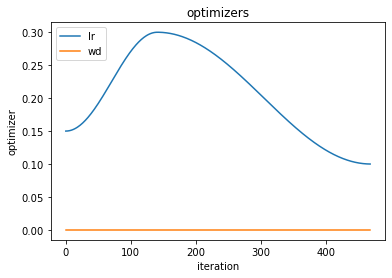

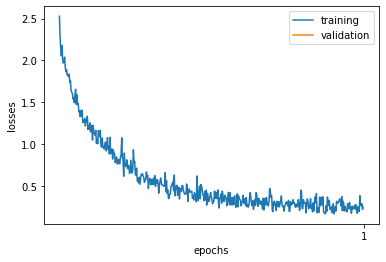

(None, None)

In [ ]:
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_loss(skip_start=0),plt.show()

#learn.find_subcription_by_cls(LR_Finder).plot_loss(),plt.show()

## steppers=[sgd_step]

In [ ]:
mm    = CnnModelManager( get_cnn_model(layers_sizes, databunch.c_in, databunch.c_out, layer=layer) )
mm.initialize(is_resnet=False)
opt = SGD(sched,max_lr=0.25)

#loss_func=LabelSmoothingCrossEntropy()
loss_func=F.cross_entropy
learn = Learner( mm.model, databunch, loss_func=loss_func)

%time learn.fit(1, opt=opt,cb_funcs=cbfs)

channels pr layers from input to output: [1, 8, 16, 32, 32, 10]
number of input and hidden layers: 4
number of output layers :          3
total number of layers:            7


epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.206942,0.203650,1.725291,0.322900,01:51


CPU times: user 6min 18s, sys: 1min, total: 7min 18s
Wall time: 1min 51s


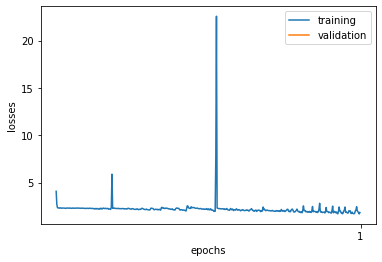

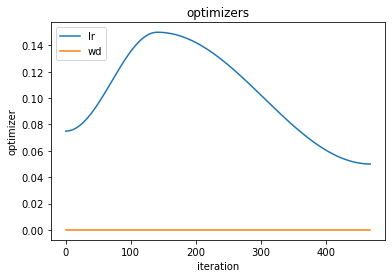

(None, None)

In [ ]:
#learn.find_subcription_by_cls(LR_Finder).plot_loss(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()

## steppers=[weight_decay, sgd_step]

In [ ]:
mm    = CnnModelManager( get_cnn_model(layers_sizes, databunch.c_in, databunch.c_out, layer=layer) )
mm.initialize(is_resnet=False)

opt = SGD(sched,max_lr=0.25, max_wd=0.01)
#print(opt.hypers[0]['lr']), print(opt.hypers[0]['wd'])
learn = Learner( mm.model, databunch, loss_func=F.cross_entropy)
%time learn.fit(1, opt=opt,cb_funcs=cbfs)

channels pr layers from input to output: [1, 8, 16, 32, 32, 10]
number of input and hidden layers: 4
number of output layers :          3
total number of layers:            7


epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.110610,0.224017,1.745712,0.392600,01:49


CPU times: user 6min 12s, sys: 58.6 s, total: 7min 10s
Wall time: 1min 49s


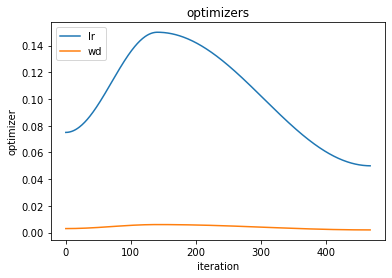

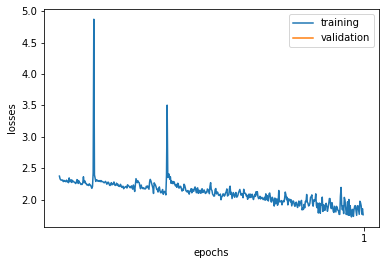

(None, None)

In [ ]:
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()

## momentum: steppers=[momentum_step,weight_decay]

In [ ]:
mm    = CnnModelManager( get_cnn_model(layers_sizes, databunch.c_in, databunch.c_out, layer=layer) )
mm.initialize(is_resnet=False)

opt   = SGD_Momentum(sched,max_lr=0.5, moms=(0.85,0.95), max_wd=1e-3 )
learn = Learner( mm.model, databunch, loss_func=F.cross_entropy)
%time learn.fit(1, opt=opt, cb_funcs=cbfs)

channels pr layers from input to output: [1, 8, 16, 32, 32, 10]
number of input and hidden layers: 4
number of output layers :          3
total number of layers:            7


epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.939661,0.252133,1.805429,0.293700,01:52


CPU times: user 6min 21s, sys: 1min, total: 7min 21s
Wall time: 1min 52s


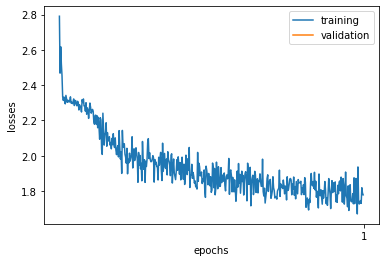

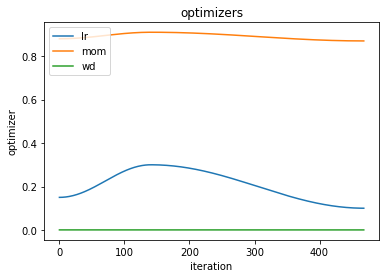

(None, None)

In [ ]:
#learn.find_subcription_by_cls(LR_Finder).plot_loss(skip_end=0),plt.show()
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()

## Adam: steppers=[adam_step]

In [ ]:
class RReLUOffset(torch.nn.ReLU):
    def __init__(self, post_relu_offset = 0.15, random_range=0.1 ): #0.15915):
        super().__init__(inplace=True)
        self.register_buffer("offset",torch.tensor(post_relu_offset, dtype=torch.float32))
        self.register_buffer("random_range",torch.tensor(random_range, dtype=torch.float32))
        self.register_buffer("central_noise",torch.tensor(post_relu_offset, dtype=torch.float32))
        
    def forward(self, x):
        if self.training:
            if not self.central_noise.size() == x.size():
                self.central_noise = torch.zeros_like(x[0,:], dtype=torch.float32, requires_grad=False)
            #torch.nn.init.uniform_(self.central_noise, (self.offset-self.random_range).item(),(self.offset+self.random_range).item()) 
            #x = super().forward(x+self.central_noise) - self.central_noise
            torch.nn.init.uniform_(self.central_noise, (-self.random_range).item(),(self.random_range).item()) 
            x = super().forward(x+self.offset+self.central_noise) - self.offset
        else:
            #x = super().forward(x+self.central_noise) - self.central_noise
            x = super().forward(x+self.offset) - self.offset
        
        return x

class RLeakyReLU(torch.nn.LeakyReLU):
    def __init__(self, negative_slope=0.22, random_range=0.1 ): #0.15915):
        super().__init__(negative_slope=negative_slope, inplace=True)
        self.register_buffer("random_range",torch.tensor(random_range, dtype=torch.float32))
        self.register_buffer("central_noise",torch.tensor(0, dtype=torch.float32))
        
    def forward(self, x):
        if self.training:
            if not self.central_noise.size() == x.size():
                self.central_noise = torch.zeros_like(x[0,:], dtype=torch.float32, requires_grad=False)
            torch.nn.init.uniform_(self.central_noise, (-self.random_range).item(),(self.random_range).item()) 
            x = super().forward(x+self.central_noise)
        else:
            x = super().forward(x)
        
        return x

#activ_func = partial(RReLUOffset,post_relu_offset = 0.15, random_range=0.15)
#activ_func = partial(RReLUOffset,post_relu_offset = 0.10, random_range=0.1)
#activ_func = partial(nn.SELU,inplace=True)
#activ_func = nn.CELU
activ_func = partial(torch.nn.RReLU,inplace=True)
#activ_func = partial(nn.PReLU,num_parameters=1, init=0.25) 
#activ_func = partial(RLeakyReLU,negative_slope=0.22, random_range=0.1) 
#activ_func = partial(nn.LeakyReLU,negative_slope=0.22) 
#activ_func = partial(nn.ReLU,inplace=True)
model = partial(xresnet18, c_in=databunch.c_in, c_out=databunch.c_out, activ_func=activ_func)()
#model = get_cnn_model(layers_sizes, data.c_in, data.c_out, layer=layer)
mm    = CnnModelManager( model )
#mm.initialize(is_resnet=True, a=0, nonlinearity="relu") #leaky_relu
#mm.initialize(is_resnet=True, a=0.015, nonlinearity="leaky_relu")
mm.initialize(is_resnet=True, a=1e-2, nonlinearity="leaky_relu")

#opt   = Adam(sched,max_lr=3e-3, moms=(0.9,0.95), max_wd = 0)#1e-5)#1e-6)
#opt   = Adam(sched,max_lr=8e-3, moms=(0.85,0.95), max_wd = 0)#1e-5)#1e-6)
opt   = Adam(sched,max_lr=5e-3, moms=(0.85,0.95), max_wd = 0)#1e-5)#1e-6)
#opt   = Adam(sched,max_lr=1e-3, moms=(0.85,0.95), max_wd = 0)#1e-5)#1e-6)
learn = Learner( mm.model, databunch, loss_func=F.cross_entropy)
#%time learn.fit(50, opt=opt, cb_funcs=cbfs)
%time learn.fit(1, opt=opt, cb_funcs=cbfs.copy()+[partial(MixUp,α=0.2)])#α=0.025)])
#%time learn.fit(5, opt=opt, cb_funcs=cbfs.copy()+[partial(MixUp,α=0.2),LRFinder])
#%time learn.fit(1, opt=opt, cb_funcs=cbfs.copy()+[LRFinder])


epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.771032,0.898267,0.096095,0.983100,02:35


CPU times: user 9min 7s, sys: 1min 5s, total: 10min 13s
Wall time: 2min 35s


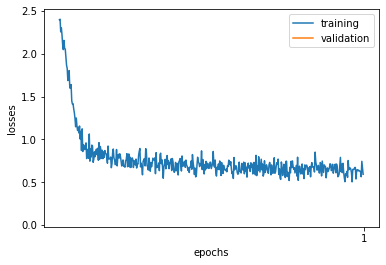

<class 'torch.nn.modules.conv.Conv2d'> torch.Size([128, 16, 28, 28])
<class 'torch.nn.modules.dropout.Dropout'> torch.Size([128, 16, 28, 28])
<class 'torch.nn.modules.batchnorm.BatchNorm2d'> torch.Size([128, 16, 28, 28])
<class 'torch.nn.modules.activation.RReLU'> torch.Size([128, 16, 28, 28])
<class 'torch.nn.modules.conv.Conv2d'> torch.Size([128, 32, 14, 14])
<class 'torch.nn.modules.dropout.Dropout'> torch.Size([128, 32, 14, 14])
<class 'torch.nn.modules.batchnorm.BatchNorm2d'> torch.Size([128, 32, 14, 14])
<class 'torch.nn.modules.activation.RReLU'> torch.Size([128, 32, 14, 14])
<class 'torch.nn.modules.conv.Conv2d'> torch.Size([128, 64, 14, 14])
<class 'torch.nn.modules.dropout.Dropout'> torch.Size([128, 64, 14, 14])
<class 'torch.nn.modules.batchnorm.BatchNorm2d'> torch.Size([128, 64, 14, 14])
<class 'torch.nn.modules.activation.RReLU'> torch.Size([128, 64, 14, 14])
<class 'torch.nn.modules.conv.Conv2d'> torch.Size([128, 64, 7, 7])
<class 'torch.nn.modules.dropout.Dropout'> torch

In [ ]:
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()
#learn.find_subcription_by_cls(LRFinder).plot_loss(skip_end=2),plt.show()
mm.summary(mnist_view(xb))


nn.LeakyReLU,negative_slope=0.22
epoch	train_loss	train_accuracy	valid_loss	valid_accuracy	time
0	0.282593	0.918260	0.107802	0.965600	01:57
1	0.088403	0.971760	0.066595	0.979000	01:54
2	0.064236	0.980140	0.043695	0.987700	01:52
3	0.046104	0.985480	0.040069	0.988800	01:49
4	0.034269	0.988700	0.030401	0.991200	01:50

RReLUOffset dp =0.2
epoch	train_loss	train_accuracy	valid_loss	valid_accuracy	time
0	0.291301	0.916020	0.102042	0.970100	01:39
1	0.089501	0.971220	0.071529	0.980200	01:39
2	0.065263	0.979160	0.044426	0.987300	01:44
3	0.047380	0.984840	0.040705	0.988700	01:45
4	0.035943	0.988340	0.036443	0.989700	01:44
nn.LeakyReLU negative slope = 0.22, dp =0.2
epoch	train_loss	train_accuracy	valid_loss	valid_accuracy	time
0	0.312350	0.909100	0.076031	0.976600	01:56
1	0.099954	0.969080	0.071054	0.978200	01:50
2	0.074229	0.976520	0.046156	0.986000	01:49
3	0.053614	0.983120	0.037860	0.989600	01:47
4	0.043755	0.986120	0.033932	0.989100	01:52

RReLUOffset dp =0.15
epoch	train_loss	train_accuracy	valid_loss	valid_accuracy	time
0	0.263491	0.924100	0.090427	0.972300	01:48
1	0.080762	0.975160	0.075696	0.976100	01:42
2	0.057302	0.981500	0.047867	0.986000	01:44
3	0.041253	0.987160	0.040414	0.987700	01:46
4	0.031119	0.989880	0.035690	0.990700	01:49
epoch	train_loss	train_accuracy	valid_loss	valid_accuracy	time
46	0.002601	0.998940	0.033260	0.994200	01:32
47	0.002683	0.998860	0.031301	0.993600	01:32
48	0.002592	0.999180	0.028200	0.994900	01:32
49	0.002506	0.998940	0.031109	0.994000	01:32
random range 0.05
epoch	train_loss	train_accuracy	valid_loss	valid_accuracy	time
0	0.270383	0.924200	0.067481	0.979800	01:46
1	0.080858	0.974160	0.052321	0.984000	01:45
2	0.057525	0.981540	0.050502	0.985300	01:49
3	0.041438	0.987480	0.034038	0.990100	01:49
4	0.031969	0.989540	0.027181	0.991600	01:50
random range 0.1
epoch	train_loss	train_accuracy	valid_loss	valid_accuracy	time
0	0.260961	0.926540	0.063816	0.980200	01:46
1	0.077409	0.976200	0.044228	0.987600	01:43
2	0.055123	0.982920	0.041768	0.987500	01:45
3	0.041460	0.986800	0.039065	0.989200	01:43
4	0.030207	0.990360	0.037677	0.989400	01:48
random range 0.15
epoch	train_loss	train_accuracy	valid_loss	valid_accuracy	time
0	0.275421	0.922480	0.064974	0.981200	01:57
1	0.083717	0.973620	0.057806	0.982800	01:57
2	0.058547	0.981560	0.051923	0.984700	01:58
3	0.043251	0.986360	0.047395	0.986600	01:48
4	0.032739	0.989660	0.035643	0.989700	01:46
random range 0.025
epoch	train_loss	train_accuracy	valid_loss	valid_accuracy	time
0	0.258312	0.925760	0.093886	0.969900	01:49
1	0.080177	0.974660	0.052689	0.983400	01:44
2	0.058430	0.981640	0.051558	0.985300	01:48
3	0.040972	0.986760	0.032529	0.989400	01:45
4	0.029138	0.990300	0.031472	0.991400	01:47
epoch	train_loss	train_accuracy	valid_loss	valid_accuracy	time
0	0.261120	0.925900	0.064300	0.981400	01:45
1	0.079727	0.974660	0.042132	0.987400	01:48
2	0.056772	0.982460	0.049013	0.984700	01:45
3	0.040711	0.987020	0.032128	0.990300	01:50
4	0.030780	0.989480	0.031420	0.991200	01:48
offset = 0.15, random_range=0.05
epoch	train_loss	train_accuracy	valid_loss	valid_accuracy	time
0	0.260765	0.925480	0.064600	0.979900	01:52
1	0.082303	0.973860	0.069786	0.979600	01:47
2	0.056573	0.981420	0.045290	0.985900	01:45
3	0.040231	0.986620	0.036735	0.989000	01:46
4	0.030555	0.989780	0.029462	0.991800	01:45
epoch	train_loss	train_accuracy	valid_loss	valid_accuracy	time
0	0.264640	0.925540	0.082283	0.974500	01:57
1	0.081105	0.974020	0.058184	0.983800	01:45
2	0.059533	0.981080	0.033843	0.989400	01:41
3	0.040055	0.988000	0.037411	0.989700	01:41
4	0.028907	0.990580	0.030966	0.990600	01:41
epoch	train_loss	train_accuracy	valid_loss	valid_accuracy	time
0	0.261290	0.925060	0.075366	0.976900	01:44
1	0.081224	0.974380	0.060072	0.981700	01:44
2	0.058306	0.981000	0.045393	0.987200	01:39
3	0.040148	0.986360	0.032614	0.991100	01:39
4	0.030249	0.990180	0.033033	0.990500	01:40
offset = 0.15, random_range=0.1
epoch	train_loss	train_accuracy	valid_loss	valid_accuracy	time
46	0.003222	0.998900	0.030519	0.994500	01:33
47	0.002541	0.999100	0.033652	0.994200	01:33
48	0.003163	0.998880	0.032633	0.994500	01:32
49	0.002844	0.999020	0.035770	0.993800	01:33
offset = 0.15, random_range=0.15
epoch	train_loss	train_accuracy	valid_loss	valid_accuracy	time
46	0.002808	0.999100	0.030920	0.994800	01:34
47	0.002785	0.999020	0.030506	0.994500	01:34
48	0.003955	0.998720	0.031347	0.994400	01:34
49	0.002926	0.999020	0.030456	0.995300	01:34
epoch	train_loss	train_accuracy	valid_loss	valid_accuracy	time
96	0.001648	0.999460	0.035843	0.993900	01:41
97	0.001163	0.999640	0.038448	0.993800	01:34
98	0.001089	0.999640	0.037314	0.994400	01:34
99	0.001319	0.999560	0.040035	0.994500	01:34

offset = 0.15, random_range=0.2
96	0.001430	0.999540	0.034477	0.995300	01:34
97	0.001602	0.999500	0.038260	0.994700	01:34
98	0.001999	0.999280	0.037121	0.994300	01:34
99	0.001738	0.999320	0.038505	0.994900	01:34
offset = 0.15, random_range=0.3
epoch	train_loss	train_accuracy	valid_loss	valid_accuracy	time
96	0.001630	0.999580	0.035409	0.994700	01:33
97	0.001669	0.999360	0.038094	0.994400	01:33
98	0.002152	0.999320	0.039427	0.993900	01:33
99	0.001840	0.999320	0.040100	0.994400	01:32

RLeakyReLU,negative_slope=0.22, random_range=0.1 
epoch	train_loss	train_accuracy	valid_loss	valid_accuracy	time
0	0.302418	0.913980	0.092112	0.971700	01:54
1	0.089246	0.971640	0.062777	0.981100	01:54
2	0.065457	0.978960	0.052899	0.984400	01:53
3	0.049805	0.983740	0.031775	0.989900	01:53
4	0.036793	0.987900	0.030219	0.991700	02:02
epoch	train_loss	train_accuracy	valid_loss	valid_accuracy	time
46	0.006201	0.997960	0.026166	0.994400	01:45
47	0.005418	0.998060	0.026818	0.994100	01:51
48	0.004768	0.998360	0.027573	0.994700	01:53
49	0.005316	0.998100	0.029684	0.993800	01:53
epoch	train_loss	train_accuracy	valid_loss	valid_accuracy	time
46	0.005731	0.997940	0.026608	0.993800	01:41
47	0.005781	0.998240	0.027112	0.994400	01:41
48	0.005714	0.998140	0.028586	0.993700	01:41
49	0.005864	0.998020	0.030621	0.993400	01:41

RLeakyReLU,negative_slope=0.22, random_range=0.1 , mixup=0.2
46	0.500688	0.983340	0.067012	0.994000	01:42
47	0.503568	0.983060	0.059332	0.993600	01:42
48	0.497090	0.984140	0.055999	0.993800	01:42
49	0.497275	0.984020	0.060950	0.994700	01:43

RReLU dp =0.15
epoch	train_loss	train_accuracy	valid_loss	valid_accuracy	time
0	0.357387	0.890840	0.057470	0.981900	01:55
epoch	train_loss	train_accuracy	valid_loss	valid_accuracy	time
0	0.424877	0.868820	0.058730	0.982000	01:56
epoch	train_loss	train_accuracy	valid_loss	valid_accuracy	time
0	0.359128	0.901840	0.100433	0.969900	02:03
1	0.102394	0.969140	0.055306	0.982600	02:03
2	0.073035	0.976960	0.036396	0.988800	02:03
3	0.054532	0.983740	0.030753	0.991500	02:04
4	0.042306	0.986960	0.025676	0.992700	02:04
epoch	train_loss	train_accuracy	valid_loss	valid_accuracy	time
0	0.332787	0.908140	0.066703	0.979600	02:02
1	0.099988	0.969980	0.061300	0.981300	02:02
2	0.078045	0.977260	0.046834	0.984800	02:03
3	0.067680	0.979600	0.040851	0.987200	02:03
4	0.058296	0.981980	0.039002	0.988600	02:04
5	0.048247	0.984760	0.034843	0.989900	01:59
6	0.041052	0.987020	0.027212	0.991600	01:59
7	0.032455	0.989760	0.028446	0.991600	01:58
8	0.030271	0.990500	0.024778	0.993200	01:58
9	0.027601	0.990800	0.022770	0.993500	01:59

epoch	train_loss	train_accuracy	valid_loss	valid_accuracy	time
46	0.009495	0.996940	0.023047	0.995400	01:58
47	0.008221	0.997060	0.022031	0.995200	01:58
48	0.007884	0.997600	0.023300	0.995300	01:58
49	0.008407	0.997180	0.024314	0.995100	01:58

epoch	train_loss	train_accuracy	valid_loss	valid_accuracy	time
96	0.010007	0.996600	0.019492	0.996200	02:00
97	0.009871	0.996640	0.020826	0.996000	02:00
98	0.008973	0.997040	0.021436	0.996000	02:00
99	0.008773	0.997120	0.021313	0.995800	02:00


In [ ]:
mm.summary(mnist_view(xb))
#print(dict(mm.model.named_buffers()).keys())

<class 'torch.nn.modules.conv.Conv2d'> torch.Size([128, 16, 28, 28])
<class 'torch.nn.modules.dropout.Dropout'> torch.Size([128, 16, 28, 28])
<class 'torch.nn.modules.batchnorm.BatchNorm2d'> torch.Size([128, 16, 28, 28])
<class 'torch.nn.modules.activation.RReLU'> torch.Size([128, 16, 28, 28])
<class 'torch.nn.modules.conv.Conv2d'> torch.Size([128, 32, 14, 14])
<class 'torch.nn.modules.dropout.Dropout'> torch.Size([128, 32, 14, 14])
<class 'torch.nn.modules.batchnorm.BatchNorm2d'> torch.Size([128, 32, 14, 14])
<class 'torch.nn.modules.activation.RReLU'> torch.Size([128, 32, 14, 14])
<class 'torch.nn.modules.conv.Conv2d'> torch.Size([128, 64, 14, 14])
<class 'torch.nn.modules.dropout.Dropout'> torch.Size([128, 64, 14, 14])
<class 'torch.nn.modules.batchnorm.BatchNorm2d'> torch.Size([128, 64, 14, 14])
<class 'torch.nn.modules.activation.RReLU'> torch.Size([128, 64, 14, 14])
<class 'torch.nn.modules.conv.Conv2d'> torch.Size([128, 64, 7, 7])
<class 'torch.nn.modules.dropout.Dropout'> torch

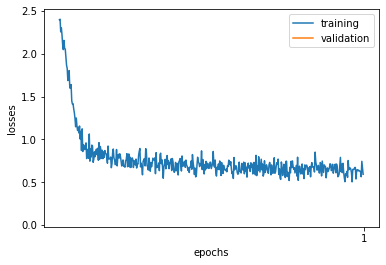

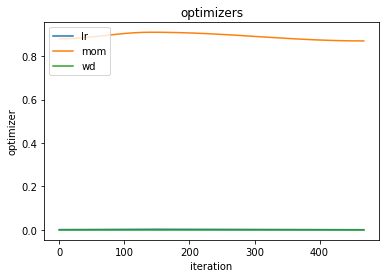

(None, None)

In [ ]:
#learn.find_subcription_by_cls(LRFinder).plot_loss(skip_end=8),plt.show()
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()

## LAMB: steppers=[lamb_step]

It's then super easy to implement a new optimizer. This is LAMB from a [very recent paper](https://arxiv.org/pdf/1904.00962.pdf):

$\begin{align}
g_{t}^{l} &= \nabla L(w_{t-1}^{l}, x_{t}) \\
m_{t}^{l} &= \beta_{1} m_{t-1}^{l} + (1-\beta_{1}) g_{t}^{l} \\
v_{t}^{l} &= \beta_{2} v_{t-1}^{l} + (1-\beta_{2}) g_{t}^{l} \odot g_{t}^{l} \\
m_{t}^{l} &= m_{t}^{l} / (1 - \beta_{1}^{t}) \\
v_{t}^{l} &= v_{t}^{l} / (1 - \beta_{2}^{t}) \\
r_{1} &= \|w_{t-1}^{l}\|_{2} \\
s_{t}^{l} &= \frac{m_{t}^{l}}{\sqrt{v_{t}^{l} + \epsilon}} + \lambda w_{t-1}^{l} \\ 
r_{2} &= \| s_{t}^{l} \|_{2} \\
\eta^{l} &= \eta * r_{1}/r_{2} \\ 
w_{t}^{l} &= w_{t}^{l-1} - \eta_{l} * s_{t}^{l} \\
\end{align}$

In [ ]:
mm    = CnnModelManager( get_cnn_model(layers_sizes, databunch.c_in, databunch.c_out, layer=layer) )
mm.initialize(is_resnet=False)

opt   = LAMB(sched,max_lr=0.02, moms=(0.85,0.95), max_wd = 1e-4)     
#opt   = LAMB(sched,max_lr=0.005, moms=(0.85,0.95), max_wd = 1e-4)     #with mixup
learn = Learner( mm.model, databunch, loss_func=F.cross_entropy)
%time learn.fit(1, opt=opt, cb_funcs=cbfs)

channels pr layers from input to output: [1, 8, 16, 32, 32, 10]
number of input and hidden layers: 4
number of output layers :          3
total number of layers:            7


epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.135968,0.597200,0.400999,0.877900,01:56


CPU times: user 6min 25s, sys: 1min 12s, total: 7min 37s
Wall time: 1min 56s


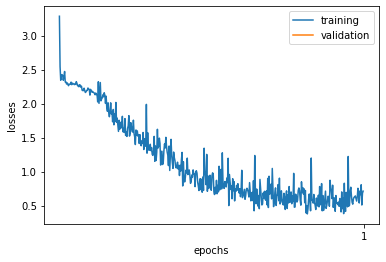

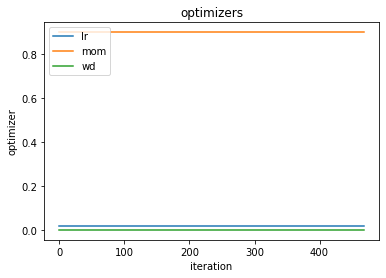

(None, None)

In [ ]:
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()

## mnist with adam and hooks

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.204277,0.938617,0.057669,0.980100,02:37


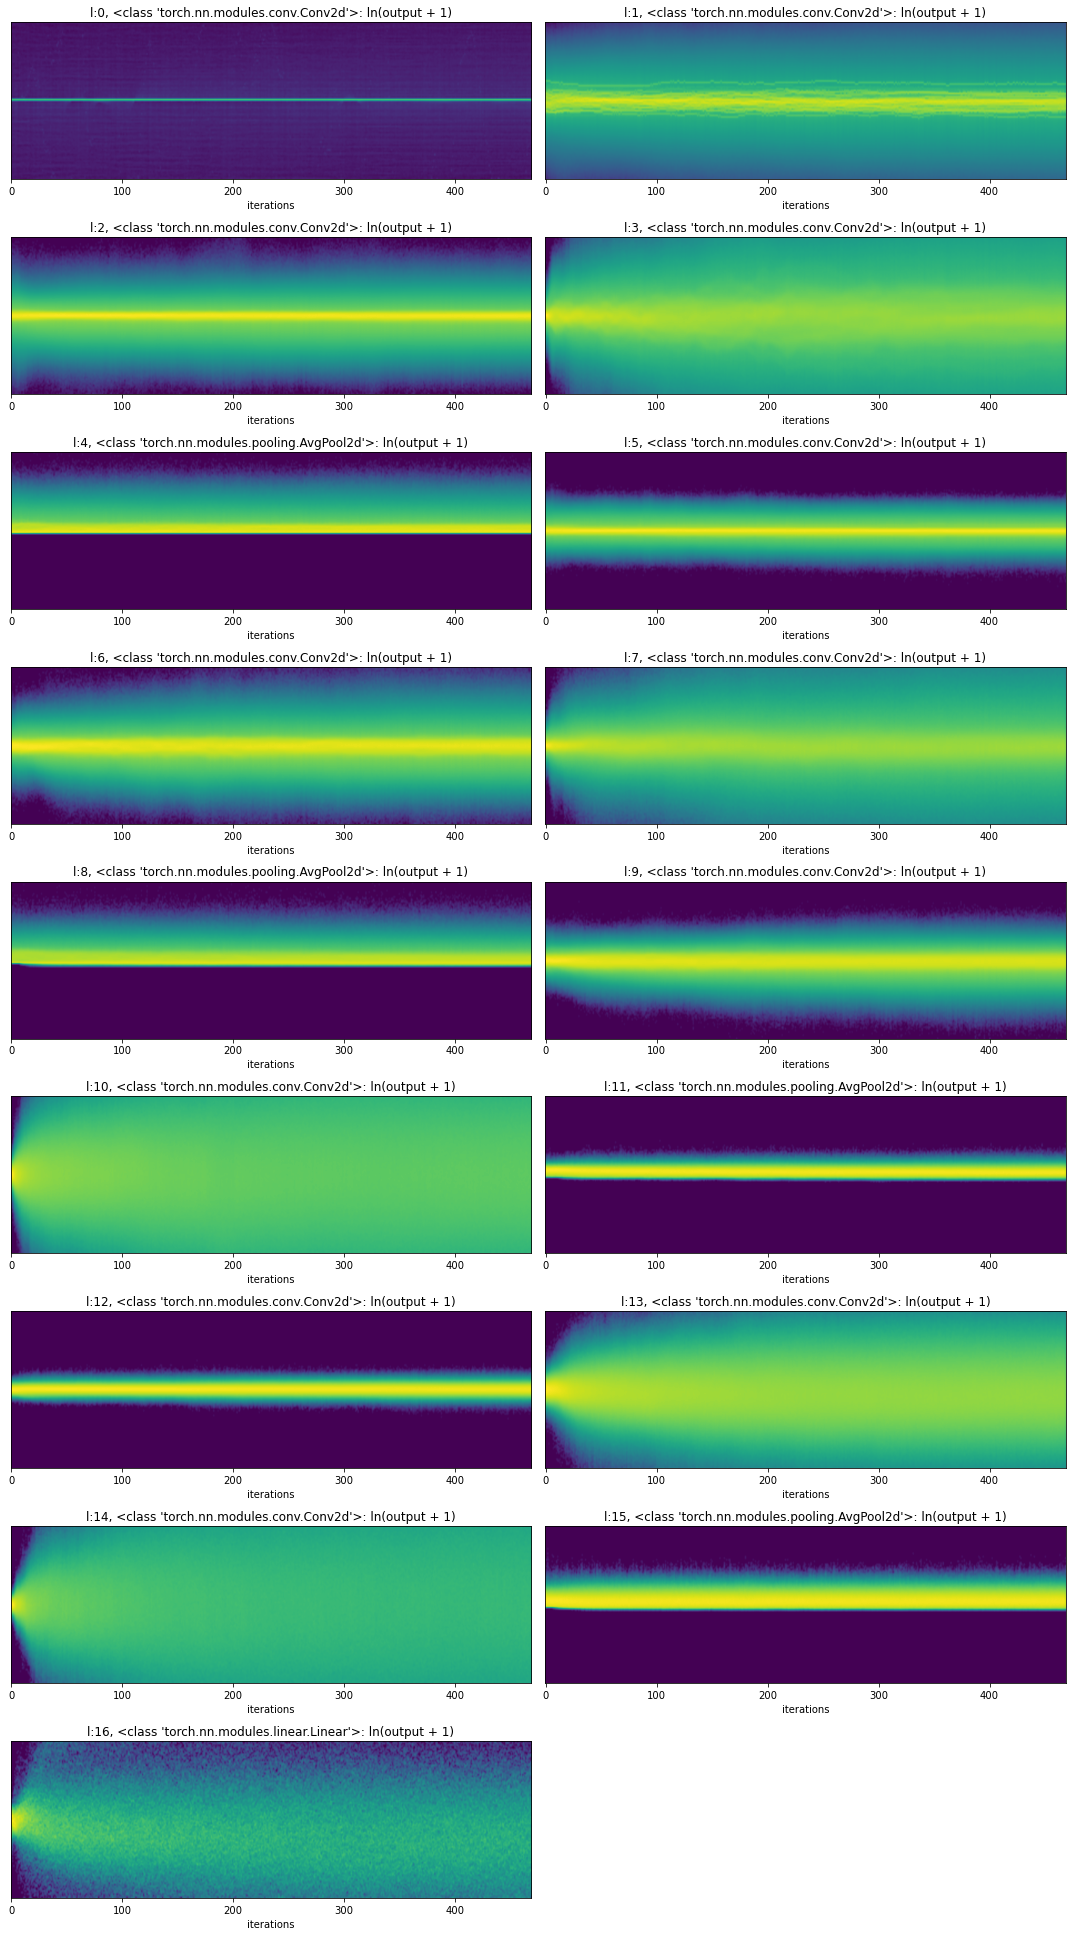

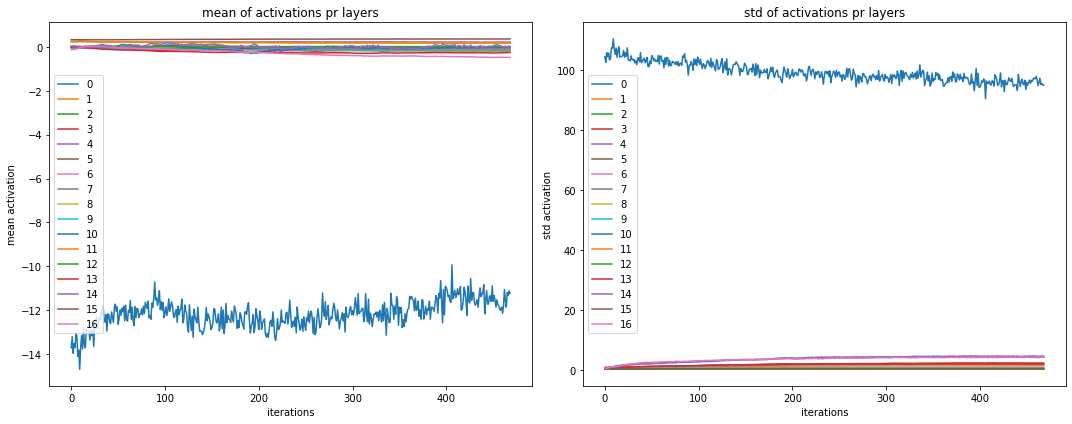

In [ ]:
#activ_func = partial(nn.ReLU,inplace=True) 
activ_func = partial(ReLUOffset) 
model = partial(xresnet18, c_in=databunch.c_in, c_out=databunch.c_out, activ_func=activ_func)()
#model = get_cnn_model(layers_sizes, data.c_in, data.c_out, layer=layer)
mm    = CnnModelManager( model )
mm.initialize(is_resnet=True, a=0.015, nonlinearity="leaky_relu")

#model = partial(xresnet18, c_in=data.c_in, c_out=data.c_out)()
#opt   = Adam(sched,max_lr=0.05, moms=(0.85,0.95), max_wd = 1e-3)
opt     = Adam(sched,max_lr=5e-3, moms=(0.85,0.95), max_wd = 1e-5)#1e-6)# xresnet18
learn   = Learner( mm.model, databunch, loss_func=F.cross_entropy)
modules = find_submodules(mm.model, lambda m: isinstance(m, (torch.nn.Conv2d,torch.nn.Linear,\
                                                             torch.nn.AvgPool2d,torch.nn.AdaptiveAvgPool2d) ))
#print(modules)
with Hooks(modules, append_stats) as hooks: 
    #learn.fit(3, opt=opt, cb_funcs=cbfs.copy()+[partial(MixUp,α=0.025)])    
    learn.fit(1, opt=opt, cb_funcs=cbfs)    
    plot_layer_stats( hooks )

In [ ]:
mnist_view(xb).shape

torch.Size([128, 1, 28, 28])

In [ ]:
mm.summary(mnist_view(xb))

<class 'torch.nn.modules.conv.Conv2d'> torch.Size([128, 16, 28, 28])
<class 'torch.nn.modules.dropout.Dropout'> torch.Size([128, 16, 28, 28])
<class 'torch.nn.modules.batchnorm.BatchNorm2d'> torch.Size([128, 16, 28, 28])
<class 'lib.model.model.ReLUOffset'> torch.Size([128, 16, 28, 28])
<class 'torch.nn.modules.conv.Conv2d'> torch.Size([128, 32, 14, 14])
<class 'torch.nn.modules.dropout.Dropout'> torch.Size([128, 32, 14, 14])
<class 'torch.nn.modules.batchnorm.BatchNorm2d'> torch.Size([128, 32, 14, 14])
<class 'lib.model.model.ReLUOffset'> torch.Size([128, 32, 14, 14])
<class 'torch.nn.modules.conv.Conv2d'> torch.Size([128, 64, 14, 14])
<class 'torch.nn.modules.dropout.Dropout'> torch.Size([128, 64, 14, 14])
<class 'torch.nn.modules.batchnorm.BatchNorm2d'> torch.Size([128, 64, 14, 14])
<class 'lib.model.model.ReLUOffset'> torch.Size([128, 64, 14, 14])
<class 'torch.nn.modules.conv.Conv2d'> torch.Size([128, 64, 7, 7])
<class 'torch.nn.modules.dropout.Dropout'> torch.Size([128, 64, 7, 7]

## mnist with LAMB and hooks

channels pr layers from input to output: [1, 8, 16, 32, 32, 10]
number of input and hidden layers: 4
number of output layers :          3
total number of layers:            7


epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.048412,0.621267,0.204823,0.934500,02:36


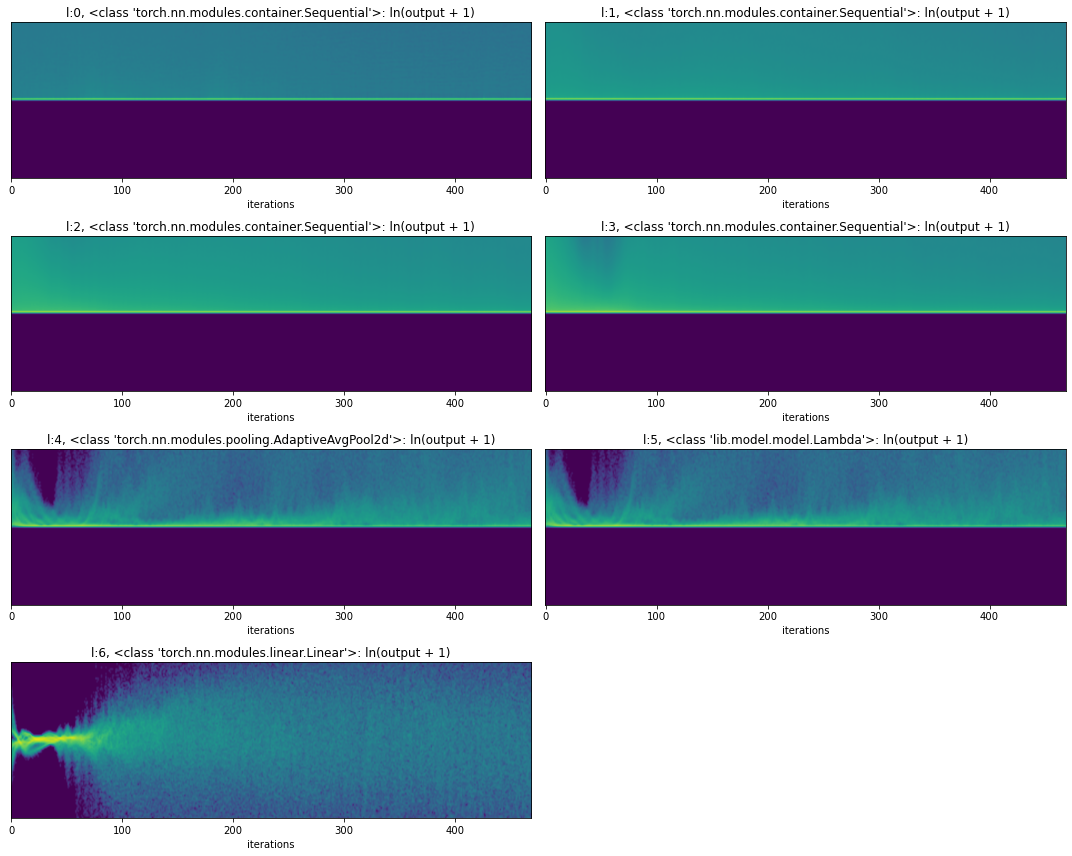

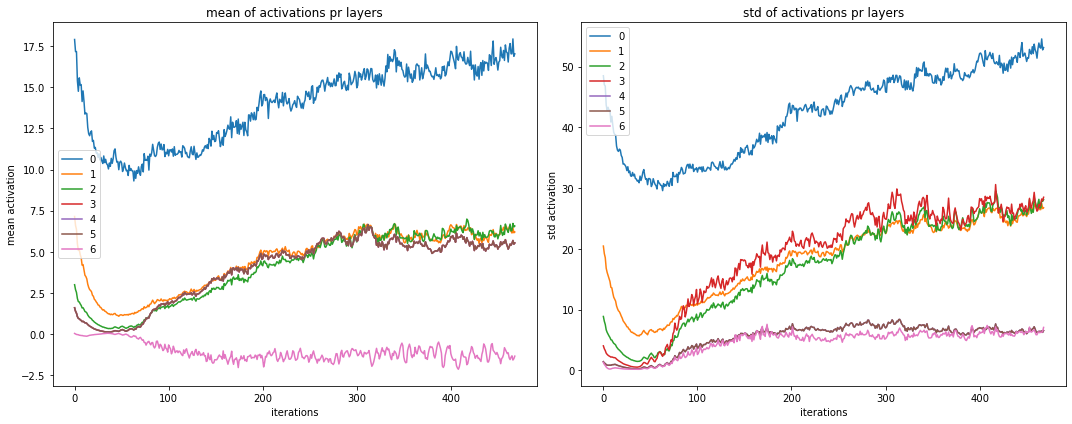

In [ ]:
#model = CnnModelManager( partial(xresnet18, c_in=data.c_in, c_out=data.c_out)() )
mm    = CnnModelManager( get_cnn_model(layers_sizes, databunch.c_in, databunch.c_out, layer=layer) )
mm.initialize(is_resnet=False)

opt   = LAMB(sched,max_lr=0.008, moms=(0.85,0.95), max_wd = 1e-6)     
learn = Learner( mm.model, databunch, loss_func=F.cross_entropy)
with Hooks(mm.model, append_stats) as hooks: 
    learn.fit(1, opt=opt, cb_funcs=cbfs)
    plot_layer_stats( hooks )